# In this notebook, we have the code to train a GAN for the multi minst data

In [8]:
import torch
import torch.optim as optim
from dataloaders import get_mnist_dataloaders, get_multi_mnist_dataloaders
from models import Generator_6layers, Discriminator_6layers
from training import Trainer
from torch.utils.data import Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_loader, _ = get_multi_mnist_dataloaders(image_size = 64,
                    path= "data/multi_mnist/MNIST_synthetic_31_3.h5", batch_size=64)


In [9]:
latent_dim = 200
img_size = (64, 64, 1)
generator = Generator_6layers(img_size=img_size, latent_dim=latent_dim, dim=64)
discriminator = Discriminator_6layers(img_size=img_size, dim=64)

print(generator)
print(discriminator)

Generator_6layers(
  (latent_to_features): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   

torch.Size([1, 200])
torch.Size([1, 1, 64, 64])


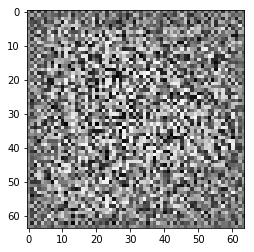

prob  tensor(0.5040, grad_fn=<SelectBackward>)


In [10]:
num_samples = 1

rand_img = torch.randn((num_samples, latent_dim))
print(np.shape(rand_img))
im = generator(rand_img)
print(np.shape(im))
tmp = im
stacked_img = np.stack((tmp.detach().numpy()[0][0],)*3, axis=-1)
plt.imshow(stacked_img)
plt.show()

prob = discriminator(im)
print("prob ", prob[0][0])

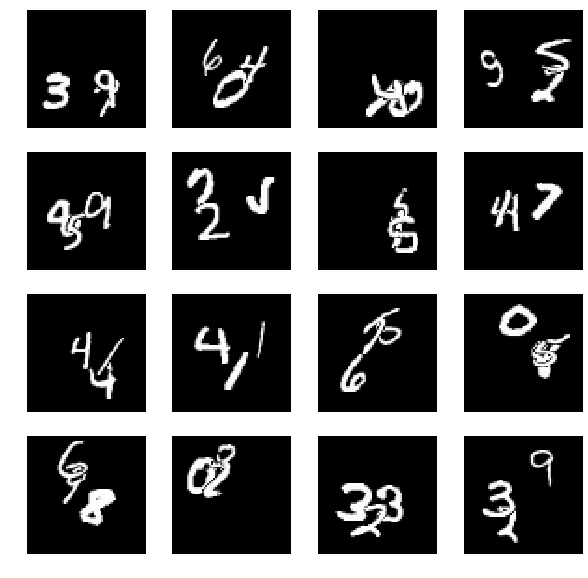

In [11]:
def show_sample_data(data_loader, n,m):

    plt.figure(figsize=(10,10))

    for data in data_loader:
        im = data[0]
        label = data[1]
        seg = data[2]

        for i in range(n*m):
            plt.subplot(n,m,i+1)
            img = np.asarray(im[i])
            stacked_img = np.stack((img[0,:,:],)*3, axis=-1)
            plt.imshow(stacked_img)
            plt.axis('off')

        break
    plt.show()
    
show_sample_data(data_loader, 4, 4)

In [12]:
# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

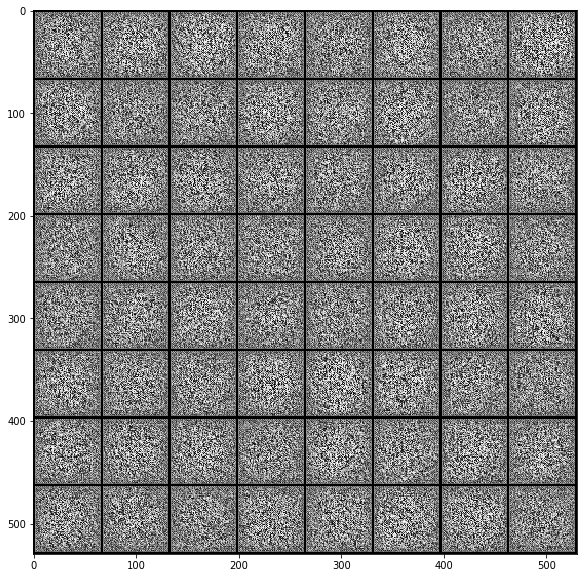

D: 9.999710083007812
GP: 9.999711036682129
Gradient norm: 1.4397654013009742e-05


KeyboardInterrupt: 

In [13]:
# Train model
epochs = 200
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
trainer.train(data_loader, epochs, save_training_gif=True, jupyter_notebook=True, save_model= True)